In [11]:
!nvidia-smi

Sat Mar 16 21:14:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.0.1 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.0.1 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.0.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.20 requires torch==2.0.1, but you have torch 2.2.1 which is incompatible.


In [13]:
!pip install poppler-utils

In [14]:
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

Looking in indexes: https://pypi.org/simple, https://huggingface.github.io/autogptq-index/whl/cu118/


In [15]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [16]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data

In [17]:
!mkdir pdfs

mkdir: cannot create directory ‘pdfs’: File exists


In [18]:
# !gdown 1NEkg1RruCBYKUZqmj_qmHmCZgvn_zYio -O pdfs/invoice_1.pdf

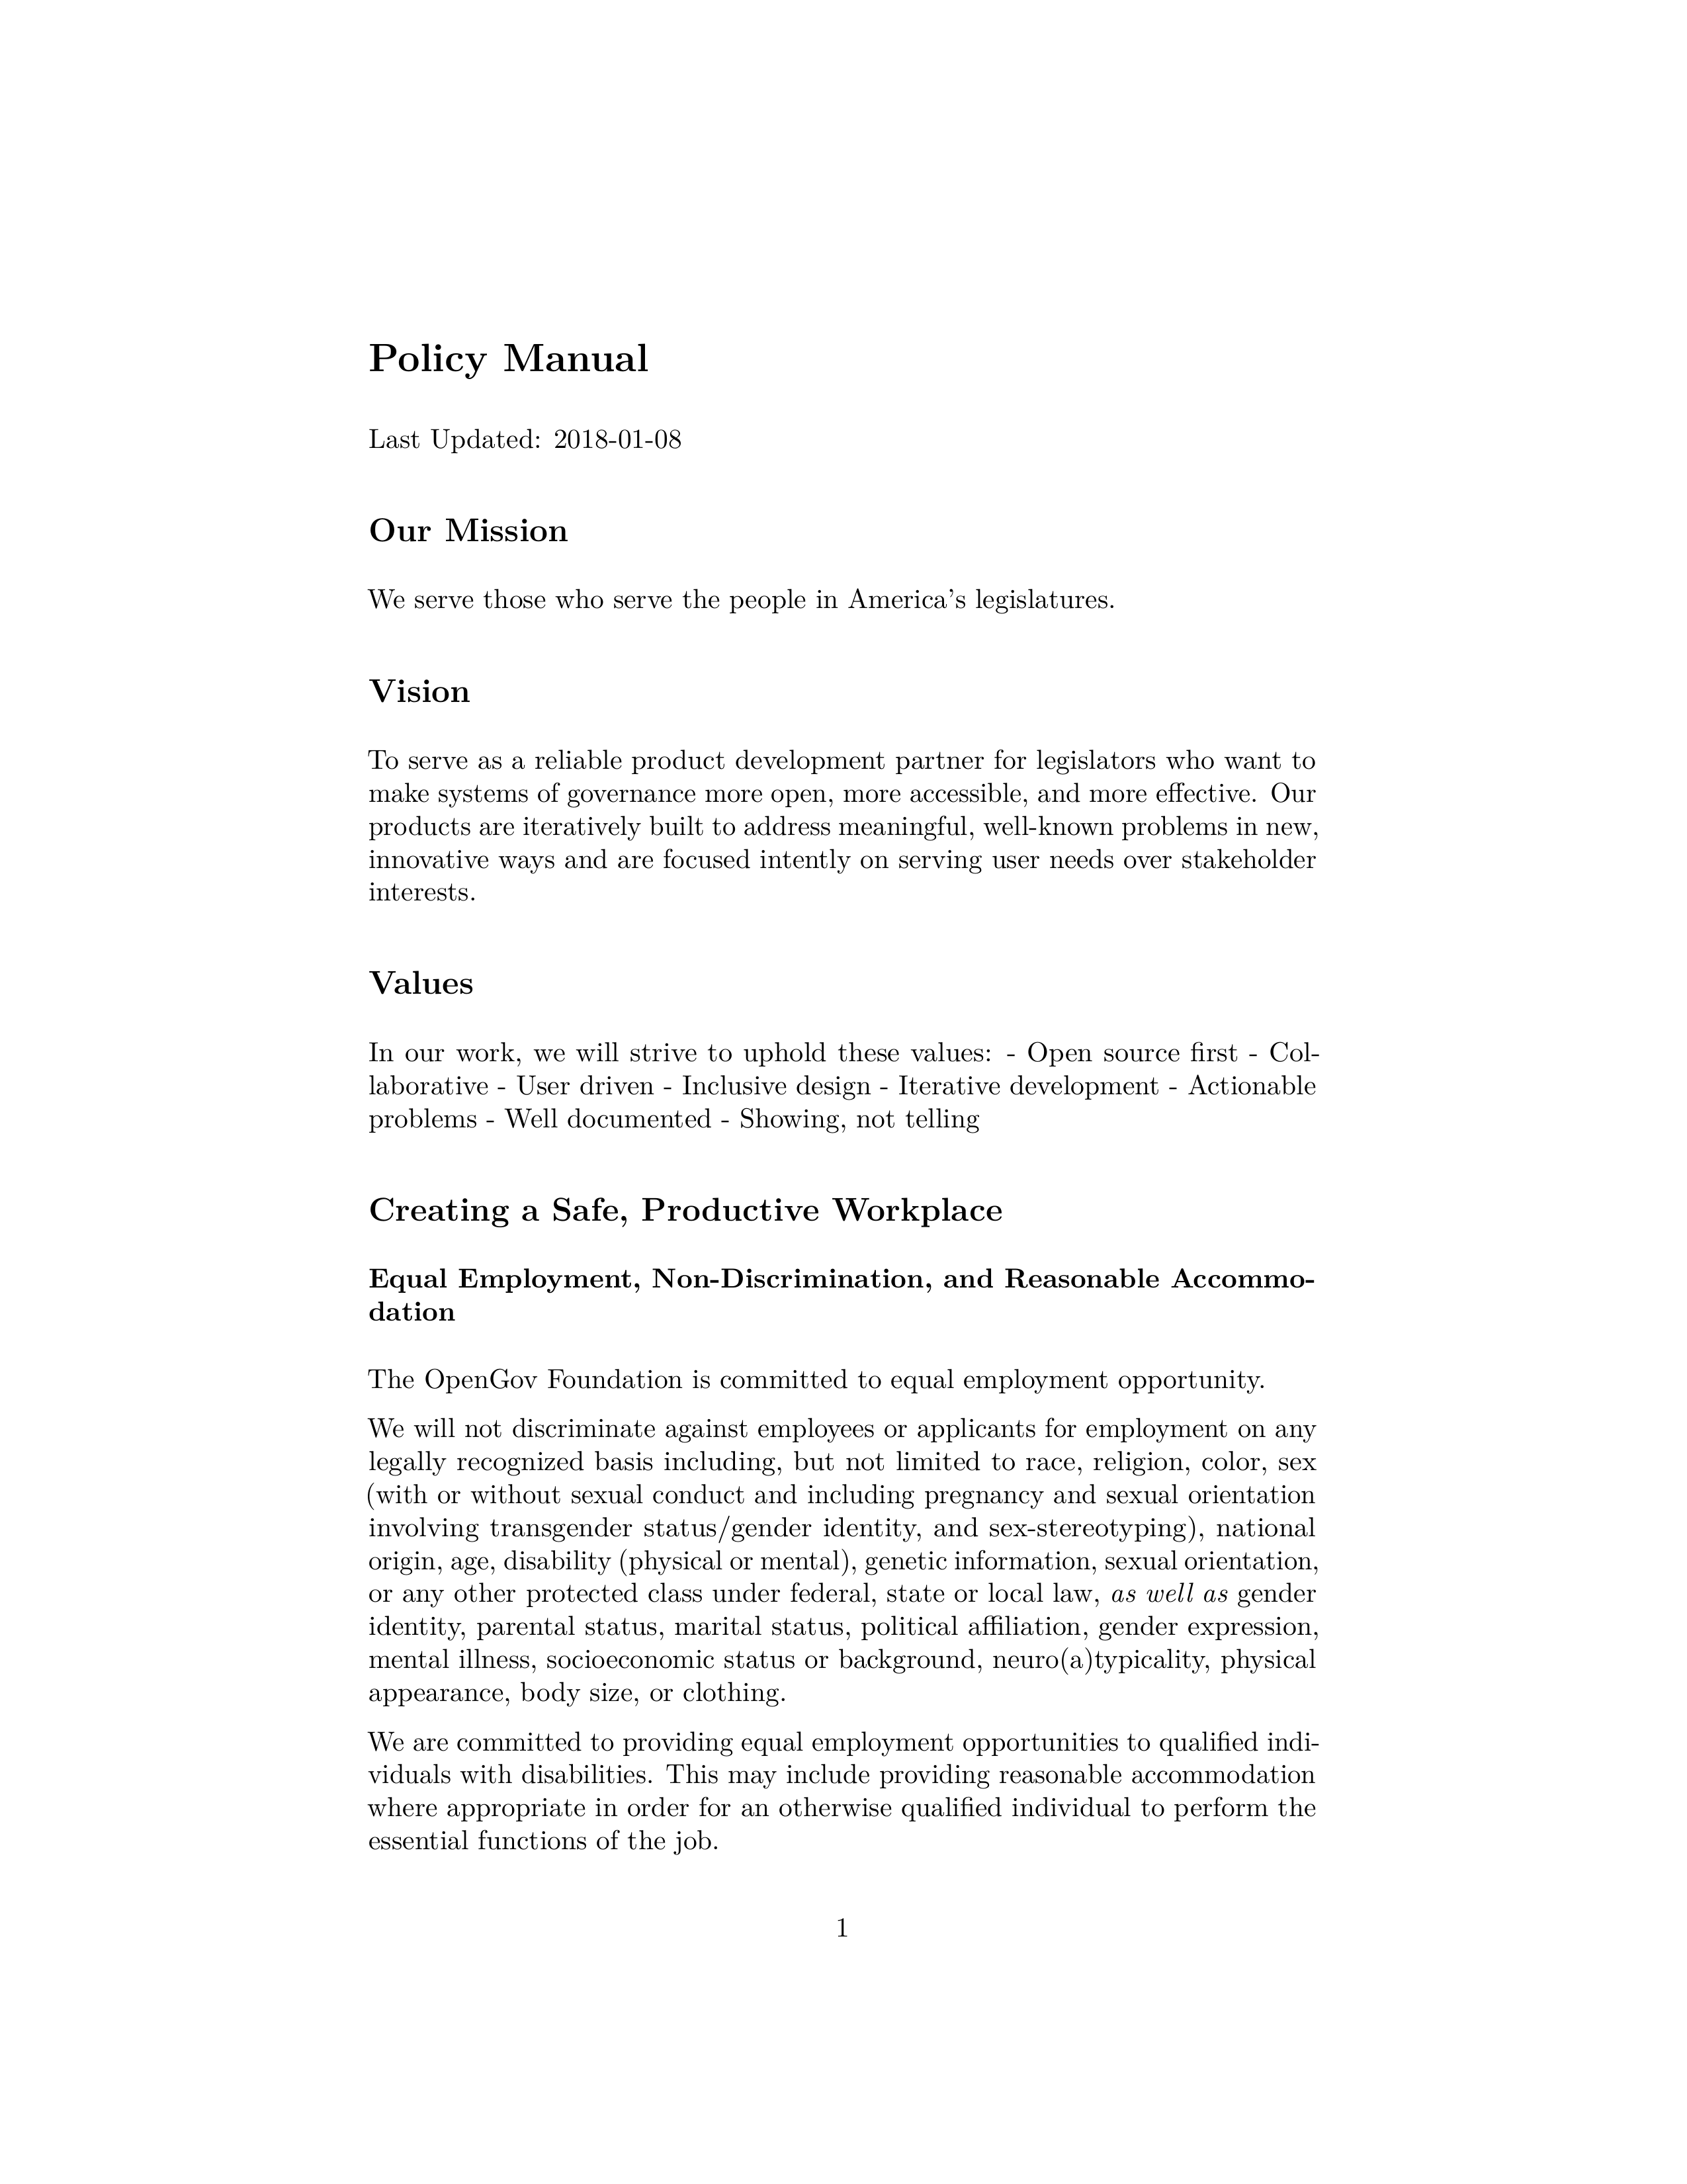

In [19]:
invoice = convert_from_path("/content/pdfs/manual.pdf", dpi=300)
invoice[0]

In [24]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

10

In [25]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

load INSTRUCTOR_Transformer
max_seq_length  512


In [22]:
# !pip install chroma

In [26]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

23

In [27]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 2.5 s, sys: 211 ms, total: 2.72 s
Wall time: 3.89 s


In [28]:
# # Step 1: Create a single paragraph of text in string format
# text= """
# 10/16/2023: Asociación Cultural Edelweiss SC was founded in 1981 and consolidates the position of two schools: Cumbres and Del Bosque
# International School. Current, request is for Del Bosque International School, which offers educations from preschool up
# to high school. The school education is religious, and they count with 156 employees. As of FY22, revenues of US$9.6M,
# an increase of 16.9% vs FY21 with EBIT of US$2.6M and net profit of US$4.2M. As of Jun,23 revenues of US$6.8M, an increase of 19.7% vs Jun,22
# with EBIT of US$1.7M. At Jun,23, assets of US$7.8M with cash of US$5.5M supported by equity of US$6.4M and financial leasing debt of US$258k (debt-to-EBIT ratio of 0.1x).
# """
# # Step 2: Use the text_splitter to split the text into chunks
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size = 100,
#     chunk_overlap  = 0,
#     length_function = len,
# )
# texts = text_splitter.split_text(text)

# # Step 3: Create embeddings (you need to replace this part with your actual code)
# # For demonstration purposes, let's assume you have embeddings for each chunk
# # embeddings = get_embeddings(texts)  # Replace with your actual function

# # Step 4: Create a Chroma database from the documents and embeddings
# db = Chroma.from_texts(texts, embeddings, persist_directory="db")

# Llama 2 13B

In [29]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

quantize_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

INFO - The layer lm_head is not quantized.
INFO:auto_gptq.modeling._base:The layer lm_head is not quantized.


In [30]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <>
{system_prompt}
<>

{prompt} [/INST]
""".strip()

In [31]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [32]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.2.1+cu121)
    Python  3.10.11 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'Marian

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

# Chat with PDF

In [ ]:
result = qa_chain("Tell me about the company.")

 I can provide information about the company based on the given context. Here are some key points:

1. The company has an Executive Director named Seamus Kraft, who is responsible for helping with payroll and benefits questions.
2. The company offers medical, dental, and vision coverage through an employer-sponsored health insurance plan. Employees pay 20% of the premium cost through payroll deduction, while the company pays 80%. Enrollment in the benefit plans is optional.
3. The company is committed to fair and collaborative performance assessments, but the specific methodology for evaluating employees' performance is still being determined.
4. Employees receive annual cost of living increases and merit-based raises, which are reviewed and approved by the Board of Directors on an annual basis.
5. The company has a staff consisting of the Executive Director, Deputy Executive Director, Director of Product, Senior Engineers, and Fellows. The Board of Directors includes a Chair, Vice Cha

In [ ]:
result = qa_chain("What is kind of negative or offensive remarks are considered unacceptable?")

 Based on the provided text, the following types of negative or offensive remarks are considered unacceptable:

1. Making negative or oﬀensive remarks based on gender expression.
2. Making negative or oﬀensive remarks based on mental illness.
3. Making negative or oﬀensive remarks based on socioeconomic status or background.
4. Making negative or oﬀensive remarks based on neuro(a)typicality.
5. Making negative or oﬀensive remarks based on physical appearance.
6. Making negative or oﬀensive remarks based on body size.
7. Making negative or oﬀensive remarks based on clothing.

These types of comments are considered unacceptable because they can diminish the value or contributions of a person or group, and can create a hostile or unwelcoming environment.


In [ ]:
result = qa_chain("How can an employee report violations?")

 Based on the provided text, an employee can report violations to one of the following members of management:

1. Executive Director
2. Chair
3. Vice Chair
4. Treasurer of the Board of Directors.


In [ ]:
result = qa_chain("What if they don't help?")

 Based on the provided text, there is no information about what to do if the person reporting the harassment does not receive a satisfactory response from the designated management members. The text only mentions reporting the situation to one of the designated management members, but it does not provide any further guidance on how to escalate the issue if the initial report is not addressed satisfactorily. Therefore, I cannot answer the question based on the provided context.


In [ ]:
result = qa_chain("What is the medical coverage policy?")

 Based on the provided context, the medical coverage policy is:

"We receive health and dental coverage and pharmacy benefits through an employer-sponsored health insurance plan. The company pays 80% of the premium cost of the plan. The employee pays 20% through payroll deduction. Enrollment in the benefit plans is optional."


In [ ]:
result = qa_chain("I paid for a office dinner last night. How can I reimburse the amount?")

 Based on the provided policy, it appears that the organization will reimburse employees for business-related meals and drinks, but only if they have pre-approved the expense. The policy states that "business-meeting meals and drinks" are eligible for reimbursement, but does not specify whether this includes office dinners.

Therefore, to ensure reimbursement, it is recommended that you obtain pre-approval from the appropriate person (such as your supervisor or the Executive Director) before incurring the expense. Additionally, you should keep receipts or other documentation to support your reimbursement request.

If you have already paid for the office dinner without pre-approval, it is possible that the organization may not reimburse the expense. However, you can still submit a reimbursement request and provide supporting documentation to see if the expense is eligible for reimbursement.


In [ ]:
result = qa_chain("I paid for out of town travel for business purposes after approval. How can I reimburse the amount? Can you tell me in steps?")

 Sure! Based on the provided policy, here are the steps you can follow to file a reimbursement request for your out-of-town travel expenses:

Step 1: Gather all relevant receipts and documents related to your out-of-town travel expenses. This should include receipts for transportation, accommodations, and any other eligible expenses.

Step 2: Classify each expense into the appropriate category (e.g., Travel - Out of Town) and provide a brief description of each expense.

Step 3: Create an image or PDF file containing all the receipts and classification information.

Step 4: Send the reimbursement request to the Executive Director for approval, including the image or PDF file of receipts and the classification information.

Step 5: Wait for the Executive Director's approval and submission of the reimbursement request for payment.

Note that according to the policy, any expenditure totaling more than $1,000 requires pre-approval by the Board of Directors and Executive Director. Therefore

In [ ]:
result = qa_chain("I may have to take a long medical leave. What are the steps I have to follow?")

 Based on the provided information, here are the steps you would have to follow if you need to take a long medical leave:

1. Inform your supervisor in writing as soon as possible, preferably before taking the leave.
2. Discuss your leave with the executive director if it exceeds two weeks.
3. Use the organization's shared password manager to share any necessary passwords with your colleagues.
4. Keep your Google calendar updated to reflect your availability.
5. Record any meetings or events you miss on your calendar.

It is important to note that the company has specific policies regarding vacation time, sick days, and family and medical leave, so it is essential to familiarize yourself with these policies before taking any extended leave. Additionally, it is recommended to communicate openly and honestly with your supervisor and team members about your needs and expectations during your leave.


In [ ]:
result = qa_chain("What is the document sharing policy to external websites and email IDs?")

 Based on the provided context, there is no information about the document sharing policy to external websites and email IDs. The provided text only discusses internal communication and collaboration within the organization using Google Suite and shared password management. Therefore, I cannot answer the question.


In [ ]:
result = qa_chain("I am travelling on a business trip to another country, any policies I should be aware of?")

 Based on the provided information, there are no specific policies mentioned regarding business trips to other countries. However, it is likely that the organization would expect employees to adhere to any local laws and regulations of the country they are visiting, and to act in a professional and respectful manner while representing the organization. It may also be advisable to check with your supervisor or the Executive Director before embarking on any international travel to ensure that it does not conflict with any important deadlines or commitments.


In [ ]:
result = qa_chain("For how long can I work remotely?")

 Based on the information provided, there is no specific mention of the duration for which employees can work remotely. The company expects employees to work 40 hours per week, but allows flexibility in terms of where and when the work gets done. Additionally, the company encourages remote work and will make all efforts to ensure a comparable work experience regardless of location. However, without further information or clarification, it is unclear for how long employees can work remotely.


In [ ]:
result = qa_chain("I did not get the raise and bonus I expected this year. What steps can I take?")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 Based on the provided context, there are no specific steps mentioned that an employee can take if they did not receive the expected raise and bonus. The document only mentions that annual cost-of-living increases will be combined with any merit increases, and these will be reviewed and approved by the Board of Directors on an annual basis. It does not provide any information on how to appeal or dispute the decision. Therefore, I don't know the answer to your question.


In [ ]:
result = qa_chain("I need to learn and move to something different in my career. How can I have that conversation? Who should I reach out to and what are the steps?")

 Based on the provided context, here is the answer to your question:

If you want to have a conversation about learning and moving to something different in your career, you should reach out to your supervisor. You can start by scheduling a meeting with them and expressing your desire to explore new opportunities. Here are some steps you can follow:

1. Prepare a brief overview of your current role, your goals, and what you hope to achieve in your career.
2. Discuss your aspirations with your supervisor and explain why you think it's important to explore new opportunities.
3. Ask for their advice on potential next steps and how they can support you in your career development.
4. If applicable, mention any relevant professional development opportunities you are interested in pursuing, such as attending conferences or taking courses.
5. Be open to feedback and suggestions from your supervisor, and be prepared to provide any necessary information about your current role and responsibiliti

In [ ]:
result = qa_chain("What business expenses are reimbursible?")

 Based on the provided context, the following business expenses are reimbursable:

1. Travel expenses (between work meetings and the office, to and from conferences and events, housing and food during conferences and events, and business-meeting meals and drinks).
2. OFFICE SUPPLIES.
3. ORGANIZATION-SPECIFIC SUBSCRIPTIONS AND/OR SOFTWARE.
4. EXPENSES ASSOCIATED WITH ORGANIZATION SPONSORED EVENTS.

Note that any expenditure totaling more than $1,000, including cumulative expenses like software subscriptions, requires pre-approval by the Board of Directors and Executive Director.
